# 회귀 실습- 자전거 대에 수요 예측
- 2011년 1월부터 2012년 12월까지 날짜/시간, 기온, 습도, 풍속 등의 정보를 기반으로 1시간 간격 동안의 자전거 대여 횟수가 기재되어 있음  
## 컬럼
1. datetime: hourly date + timestamp
2. season: 1=봄, 2=여름, 3=가을, 4=겨울
3. holiday: 1= 토, 일요일의 주말을 제외한 국경일등의 휴일, 0=휴일이 아닌 날
4. workingday: 1=토, 일요일의 주말 및 휴일이 아닌 주중, 0=주말 및 휴일
5. weathre:
    - 1= 맑음, 약간 구름 낀 흐림
    - 2= 안개, 안개 + 흐름
    - 3= 가벼운 눈, 가벼운 비 + 천둥
    - 4= 심한 눈/비, 천둥/번개
6. temp: 온도(섭씨)
7. atemp: 체감온도(섭씨)
8. humidity: 상대습도
9. windspeed: 풍속
10. casual: 사전에 등록되지 않는 사용자가 대여한 횟수
11. registered: 사전에 등록된 사용자가 대영한 횟수
12. count: 대여 횟수

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

bike_df = pd.read_csv(r'D:\Python\bike_train.csv')
print(bike_df.shape)
bike_df.head(5)

(10886, 12)


,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [2]:
bike_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10886 non-null  object 
 1   season      10886 non-null  int64  
 2   holiday     10886 non-null  int64  
 3   workingday  10886 non-null  int64  
 4   weather     10886 non-null  int64  
 5   temp        10886 non-null  float64
 6   atemp       10886 non-null  float64
 7   humidity    10886 non-null  int64  
 8   windspeed   10886 non-null  float64
 9   casual      10886 non-null  int64  
 10  registered  10886 non-null  int64  
 11  count       10886 non-null  int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.7+ KB


In [3]:
# 문자열을 datetime 타입으로 변경
bike_df['datetime'] = bike_df.datetime.apply(pd.to_datetime)

# datetime 타입에서 년, 월, 일, 시간 추출
bike_df['year'] = bike_df.datetime.apply(lambda x: x.year)
bike_df['month']= bike_df.datetime.apply(lambda x: x.month)
bike_df['day']  = bike_df.datetime.apply(lambda x: x.day)
bike_df['hour'] = bike_df.datetime.apply(lambda x: x.hour)
bike_df.head(3)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,day,hour
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,2011,1,1,0
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,2011,1,1,1
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2011,1,1,2


In [4]:
# casual 칼럼은 사전에 등록하지 않은 사용자의 자전거 대여 횟수
# registered 컬럼은 사전에 등록한 사용자의 대여 횟수
# count = casual + regeistered 이므로 이 둘과 datetime을 삭제

drop_columns = ['datetime','casual','registered']
bike_df.drop(drop_columns, axis=1, inplace=True)

In [5]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# log 값 변환 시 NaN 등의 이슈로 log()가 아닌 log1p()를 이용해 RMSLE 계산
def rmsle(y, pred):
    log_y = np.log1p(y)
    log_pred = np.log1p(pred)
    squared_error = (log_y-log_pred) ** 2
    rmsle = np.sqrt(np.mean(squared_error))
    return rmsle

# 사이킷런의 mean_square_error( )를 이용해 RMSE 계산
def rmse(y, pred):
    return np.sqrt(mean_squared_error(y, pred))

# MSE, RMSE, RMSLE를 모두 계산
def evaluate_regr(y, pred):
    rmsle_val = rmsle(y, pred)
    rmse_val = rmse(y, pred)
    mae_val = mean_absolute_error(y, pred)
    print('RMSLE: {0:.3f}, RMSE: {1:.3f}, MAE: {2:.3f}'.format(rmsle_val, rmse_val, mae_val))

- 다음과 같은 RMSLE은 구현은 오버플로나 언더플로 오류를 발생하기 쉬움
```
def rmsle(y, pred):
    msle = mean_squared_log_error(y, pred)
    rmsle =np.sqrt(mse)
    return rmsle
```
- 이 코드는 데이터 값으 크기에 따라 오버플로/언더플로 오류가 발생하기 쉬움

## 로그 변환, 피처 인코딩과 모델 학습/예측/평가
- 회귀모델을 적용하기 전에 
    - 데이터 세트에 대해서 결괏값이 정규분포로 돼 있는지 확인하는 것해야 하며
    - 카테고리형 회귀 모델의 경우 원-핫 인코딩으로 피처를 인코딩하는 것

In [6]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso

y_target = bike_df['count']
X_features = bike_df.drop(['count'], axis=1, inplace=False)

X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, 
                                                   test_size=0.3, random_state=0)
lr_reg=LinearRegression()
lr_reg.fit(X_train, y_train)
pred = lr_reg.predict(X_test)

evaluate_regr(y_test, pred)

RMSLE: 1.165, RMSE: 140.900, MAE: 105.924


In [7]:
# 실제 값과 예측 값이 어느정도 차이가 나는지 DataFrame의 칼럼으로 만들어서 오류 값이 가장 큰 순으로 5개만 확인
def get_top_error_data(y_test, pred, n_tops=5):
    # DataFrame의 칼럼으로 실제 대여 횟수(count)와 예측값을 서로 비교할 수 있도록 생성
    result_df = pd.DataFrame(y_test.values, columns=['real_count'])
    result_df['predicted_count'] = np.round(pred)
    result_df['diff']=np.abs(result_df['real_count']-result_df['predicted_count'])
    
    # 예측 값과 실제 값이 가장 큰 데이터 순으로 출력
    return result_df.sort_values('diff', ascending=False)[:n_tops]

get_top_error_data(y_test, pred, n_tops=5)

,real_count,predicted_count,diff
1618,890,322.0,568.0
3151,798,241.0,557.0
966,884,327.0,557.0
412,745,194.0,551.0
2817,856,310.0,546.0


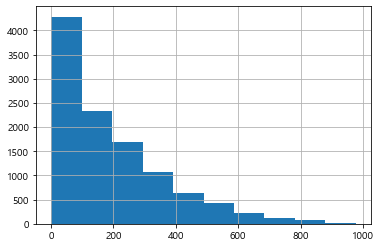

In [8]:
y_target.hist();

- count( ) 컬럼값이 정규분포가 아닌 0 ~ 200 사이에 왜곡이 돼어 있음
- 이렇게 왜곡된 값을 정규 분포 형태로 바꾸는 가장 일반적인 방법은 로그를 적용해 변환하는 것

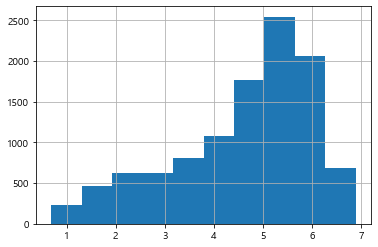

In [9]:
y_log_transform = np.log1p(y_target)
y_log_transform.hist();

In [10]:
# 타깃 칼럼인 count 값을 log1p로 로그 변환
y_target_log = np.log1p(y_target)

# 로그 변환된 y_target_log를 반영해 학습/테스트 데이터 세트 분할
X_train, X_test, y_train, y_test = train_test_split(X_features, y_target_log,
                                                    test_size=0.3, random_state=0)
lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)
pred = lr_reg.predict(X_test)

# 테스트 데이터 세트의 Target 값은 로그 변환됐으므로 다시 exmp1를 이용해 원래 스케일로 변환
y_test_exp = np.expm1(y_test)

# 예측 값 역시 로그 변환된 타깃 기반으로 학습돼 예측됐으므로 다시 exmp1로 스케일 변환
pred_exp = np.expm1(pred)

evaluate_regr(y_test_exp, pred_exp)

RMSLE: 1.017, RMSE: 162.594, MAE: 109.286


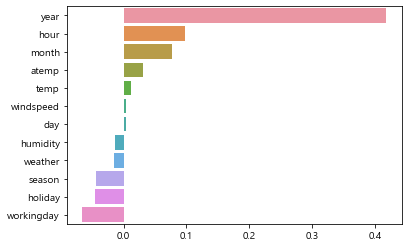

In [11]:
coef = pd.Series(lr_reg.coef_, index=X_features.columns)
coef_sort = coef.sort_values(ascending=False)
sns.barplot(x=coef_sort.values, y=coef_sort.index);

- RMSLE 오류는 줄어들었으나(1.165 -> 1.017) RMSE는 오히려 늘어남(140.9 -> 162.594)
- 각 피처의 회귀 계수값을 시각화했을 때 Year 피처의 회귀 계수값이 독보적으로 큰 값을 가지고 있음
    - 그 이유는 Year 피처는 연도를 뜻하며 카테고리(Category)형 피처지만 숫자로 이루어져 있음
    - 더군다나 아주 큰 값인 2011, 2012로 돼 있음
    - 사이킷런에는 카테고리형 만을 위한 데이터 타입이 없어 연속형으로의 회귀 결과에 영향을 미침
    - 따라서 선형회귀에서는 이러한 피처 인코딩에 원-핫 인코딩을 적용해 변환해야 함

In [14]:
# 'year','month','day','hour' 등의 피처를 One-Hot Encoding
X_feature_ohe = pd.get_dummies(X_features, columns=['year','month','day','hour','holiday',
                                                    'workingday','season','weather'])

# 원-핫 인코딩이 적용된 피처 데이터 세트 기반으로 학습/예측 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X_feature_ohe, y_target_log,
                                                    test_size=0.3, random_state=0)

# 모델과 학습/테스트 데이터 세트를 입력하면 성능 평가 수치를 반환
def get_model_predict(model, X_train, X_test, y_train, y_test, is_expm1=False):
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    if is_expm1:
        y_test=np.expm1(y_test)
        pred=np.expm1(pred)
    print('###', model.__class__.__name__,'###')
    evaluate_regr(y_test, pred)
# end of function get_model_predict

# 모델 별로 평가 수행
lr_reg = LinearRegression()
ridge_reg = Ridge(alpha=10)
lasso_reg = Lasso(alpha=0.01)

for model in [lr_reg, ridge_reg, lasso_reg]:
    get_model_predict(model, X_train, X_test, y_train, y_test, is_expm1=True)

### LinearRegression ###
RMSLE: 0.590, RMSE: 97.688, MAE: 63.382
### Ridge ###
RMSLE: 0.590, RMSE: 98.529, MAE: 63.893
### Lasso ###
RMSLE: 0.635, RMSE: 113.219, MAE: 72.803


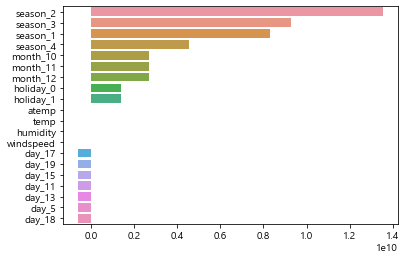

In [16]:
coef = pd.Series(lr_reg.coef_, index=X_feature_ohe.columns)
coef_sort = coef.sort_values(ascending=False)[:20]
sns.barplot(x=coef_sort.values, y=coef_sort.index);

In [17]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

# 랜덤포레스트, GBM, XGBoost, LightGBM model별로 평가수행
rf_reg = RandomForestRegressor(n_estimators=500)
gbm_reg= GradientBoostingRegressor(n_estimators=500)
xgb_reg= XGBRegressor(n_estimators=500)
lgbm_reg= LGBMRegressor(n_estimators=500)

for model in [rf_reg, gbm_reg, xgb_reg, lgbm_reg]:
    # XGBoost의 경우 DataFrame이 입력될 경우 버전에 따라 오류 발생 가능. ndarray로 변환
    get_model_predict(model, X_train.values, X_test.values, 
                      y_train.values, y_test.values, is_expm1=True)

### RandomForestRegressor ###
RMSLE: 0.355, RMSE: 50.390, MAE: 31.250
### GradientBoostingRegressor ###
RMSLE: 0.330, RMSE: 53.336, MAE: 32.745
### XGBRegressor ###
RMSLE: 0.342, RMSE: 51.732, MAE: 31.251
### LGBMRegressor ###
RMSLE: 0.319, RMSE: 47.215, MAE: 29.029
